In [1]:
import os
from PIL import Image, ImageFilter
import numpy as np 

#Dataset Directory 
alphabet_dir = "D:/Ramana/Summer23/AI_PROJECT/COMP-6721-SUMMER-PROJECT/ASL_Dataset/Train"
 
images = []
labels = []

In [2]:
max_images_per_folder = 100
size = (256, 256)  
def horizontal_flip(image):
    flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
    return flipped_image

# Noise removal: Gaussian blur
def remove_noise(image):
    pil_image = Image.fromarray(np.uint8(image*255))  
    denoised_image = pil_image.filter(ImageFilter.GaussianBlur(radius=2))
    denoised_array = np.array(denoised_image) / 255.0  
    return denoised_array

images = []
labels = []

for folder_name in os.listdir(alphabet_dir):
    folder_path = os.path.join(alphabet_dir, folder_name)

    image_counter = 0

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            if image_counter >= max_images_per_folder:
                break
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)

            image = image.resize(size)

            image = image.convert('L')

            image = np.array(image) / 255.0

            image = remove_noise(image)

            images.append(image)
            labels.append(folder_name)
            image_counter += 1

images = np.array(images)
labels = np.array(labels)

In [3]:
images.shape

(2800, 256, 256)

# PCA

In [4]:
# Reshape the image data
num_images = images.shape[0]
flattened_images = images.reshape(num_images, -1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_images = scaler.fit_transform(flattened_images)


In [5]:
from sklearn.decomposition import PCA

num_components = 10  # Number of principal components to keep
pca = PCA(n_components=num_components)
reduced_images = pca.fit_transform(standardized_images)


In [6]:
reconstructed_images = pca.inverse_transform(reduced_images)

In [7]:
reconstructed_images.shape

(2800, 65536)

# CPU Training

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import numpy as np

X = reconstructed_images
y = labels

X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X, y, test_size=0.8, stratify=y)

X_labeled = X_labeled.reshape(X_labeled.shape[0], -1)
X_unlabeled = X_unlabeled.reshape(X_unlabeled.shape[0], -1)

params = {'criterion': ['entropy'],
                    'max_depth': [8]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=2411), params, verbose=4, cv=3, n_jobs=-1)
grid_search_cv.fit(X_labeled, y_labeled)


model = grid_search_cv.best_estimator_
pseudo_labels = model.predict(X_unlabeled)

confidence_threshold = np.percentile(model.predict_proba(X_unlabeled).max(axis=1), 90)
high_confidence_indices = np.where(model.predict_proba(X_unlabeled).max(axis=1) >= confidence_threshold)[0]
high_confidence_samples = X_unlabeled[high_confidence_indices]
high_confidence_labels = pseudo_labels[high_confidence_indices]

X_combined = np.concatenate((X_labeled, high_confidence_samples), axis=0)
y_combined = np.concatenate((y_labeled, high_confidence_labels), axis=0)

num_iterations = 1
for _ in range(num_iterations):
    grid_search_cv.fit(X_combined, y_combined)
    model = grid_search_cv.best_estimator_
    pseudo_labels = model.predict(X_unlabeled)
    confidence_threshold = np.percentile(model.predict_proba(X_unlabeled).max(axis=1), 90)
    high_confidence_indices = np.where(model.predict_proba(X_unlabeled).max(axis=1) >= confidence_threshold)[0]
    high_confidence_samples = X_unlabeled[high_confidence_indices]
    high_confidence_labels = pseudo_labels[high_confidence_indices]
    X_combined = np.concatenate((X_labeled, high_confidence_samples), axis=0)
    y_combined = np.concatenate((y_labeled, high_confidence_labels), axis=0)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [9]:

# Final model evaluation
accuracy = grid_search_cv.best_score_
print(f"Final Model Accuracy: {accuracy}")

Final Model Accuracy: 0.9623161878425696


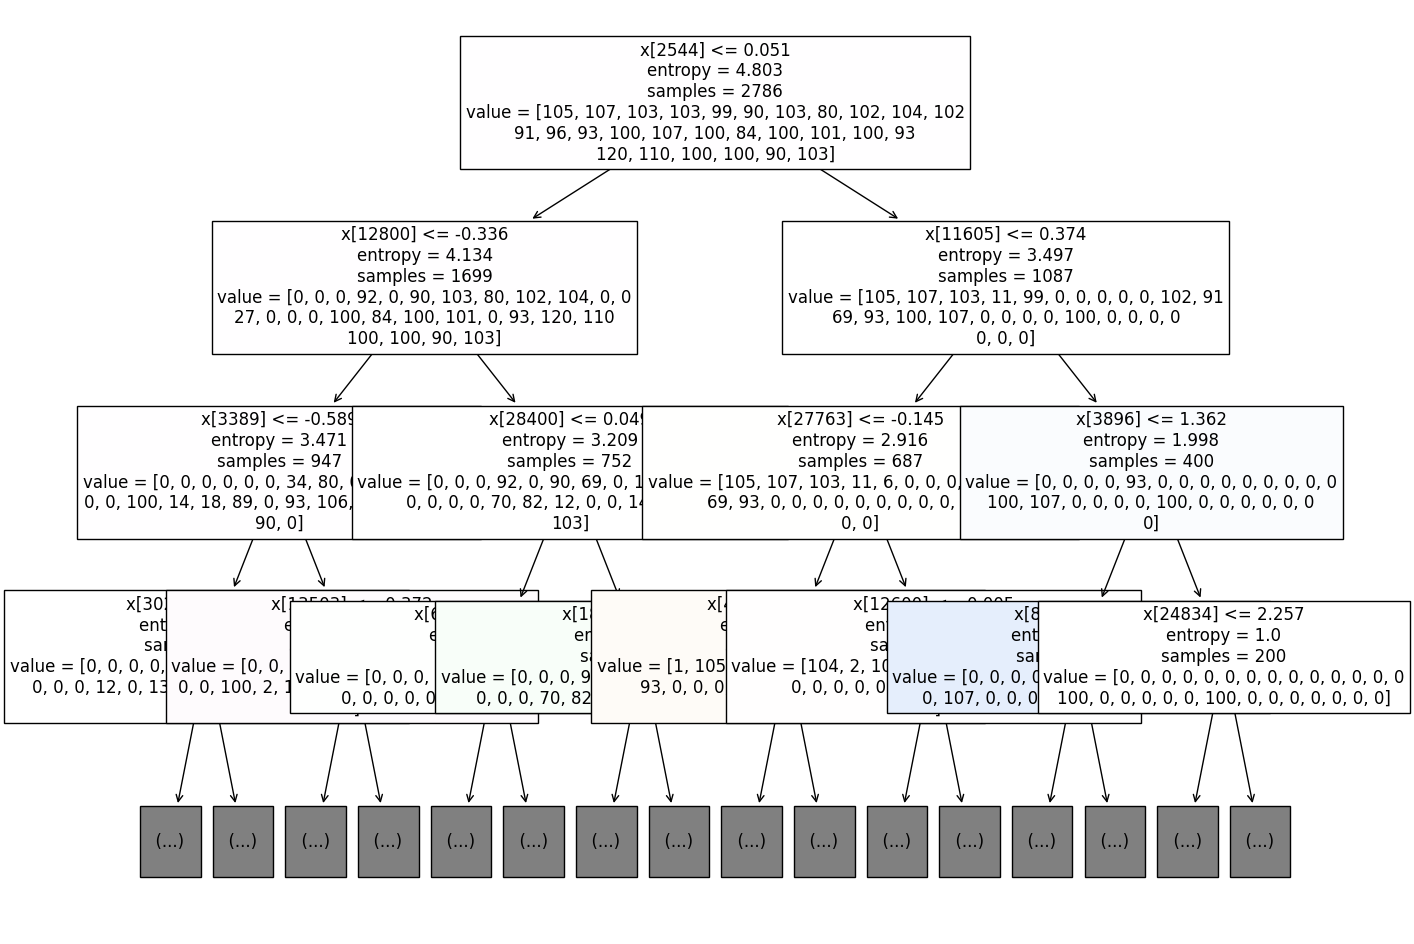

In [12]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 12))
plot_tree(grid_search_cv.best_estimator_, max_depth=3, filled=True, fontsize=12)
# plt.savefig("decision_tree.png", format="png")  
plt.show()